# 2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?



## Resumen
En este ejercicio nuestro dataset va a ser un conjunto de tweets dentro de un fichero json. Es decir es informacion sin etiquetar y por tanto para ver que temas aparecen deberemos usar algoritmos propios de Unsupervised Learning.


Como el objetivo de este ejercicio es establecer la tematica de los tweets de nuestro dataset estamos hablando de **Topic Modeling** y uno  los algoritmos mas comunes de este tipo de problemáticas es el conocido como **LDA**(Latent Dirichlet Allocation)

Para que el numero de registros no sea un problema a la hora de entrenar el modelo, en lugar de usar el dataset conjunto con los tweets de Trump y Obama (dataset_2.json), usaremos solo el que contiene los tweets de Obama (BarackObama.json) y dejaremos el de Trump para el ejercicio 3

## Librerias/Imports
Tanto gensim como spacy vienen ya preinstaladas

In [1]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.5MB/s 
     |████████████████████████████████| 552kB 36.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=0e117c929727d570d9db82f10abf666e699c93ca64ab8a10fe879982276ed31f
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=93dba5626e43f2a89869bcc8416aa045fab2ef6d0de533e54b54dbe14d042844
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import numpy as np
import pandas as pd
import io

import spacy
import gensim
from os.path import join
import csv
#from stop_words import get_stop_words
from string import punctuation
import re

import pyLDAvis.gensim
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

## Funciones

In [0]:
# En la funcion preprocess pondremos diferentes opciones de preprocesado del texto
# e iremos probando con distintas combinaciones (comentando y descomentando) para ver
# cual nos genera un mejor modelo.
def preprocess(text, lema = True):

  # Eliminamos los espacios en blanco por delante y detras
  text = text.strip()

  #Tokenizamos
  doc = nlp(text)
  words = [t for t in doc]

  # Quitamos los signos de puntuacion
  #words = [t for t in doc if not t.is_punct]
  
  # Quitamos las stop_words
  words = [t for t in words if not t.is_stop]

  # Eliminamos palabras de tamaño menor de tres
  #words = [t for t in words if len(t) > 2 and  t.text.isalpha()]
   
  # Lematizamos
  if(lema):
    words = [t.lemma_ for t in words]
  else:
    words = [t.text for t in words]

  # Ponemos las palabras en minusculas
  words = [t.lower() for t in words]

  # Cambiamos las urls por <URL>
  #words = ['<URL>' if "http" in word else word for word in words]

  # Eliminamos las urls
  words = ['' if "http" in word else word for word in words]

  # Por ultimo eliminamos los caracteres que no queremos que aparezcan
  all_printables_chars = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'
  printables_chars = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!?'
  words = [''.join([c if c in printables_chars else '' for c in word]) for word in words]
  
  # Generamos el string de salida
  result = ' '.join(words)
  return result.strip()

## Dataset

In [0]:
from google.colab import files
import json

In [5]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving BarackObama.json to BarackObama.json
User uploaded file "BarackObama.json" with length 373852 bytes


In [7]:
json_file = uploaded['BarackObama.json']
dataset = json.loads(json_file)
len(dataset)


2894

### Preproceso
Vamos a reutilizar la funcion de preproceso del ejercicio anterior con alguna modificación. por ejemplo cmabiamos las urls que aparecen en los tweets por el token <URL>

In [0]:
# En esta ocasion usamos el modelo en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [0]:
#Extraemos el texto de los tweets del diccionario
documents = []
for key, value in dataset.items():
  #Aplicamos el preproceso al texto, en caso de no querer aplicar ningun preproceso bastara con comentar esta linea
  value = preprocess(value,False)
  documents.append(value)

In [0]:
#documents[0:10]

In [0]:
# Tokenizamos documents
tokenize_documents = []

for doc in documents:
  doc_tok = [tok.text for tok in nlp(doc, disable=['parser', 'tagger', 'ner'])]
  tokenize_documents.append(doc_tok)

In [0]:
#tokenize_documents[0]

In [13]:
# Generamos el vocabulario
vocab = set([t for doc in tokenize_documents for t in doc])

w2id = {k:i for i, k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}

'unique tokens {}'.format(len(w2id))

'unique tokens 3802'

In [0]:
# Usamos Gensim para mapear el vocabulario a enteros y poder usar BoW para generar el corpus
from gensim.corpora import Dictionary
gensim_dict = Dictionary(tokenize_documents)
corpus = [gensim_dict.doc2bow(doc) for doc in tokenize_documents]

## Implementamos el Modelo (LDA API) usando Gensim

In [0]:
from gensim import corpora, models, similarities
from math import exp

In [0]:
# El numero de topicos del modelo es un hiperparametro que debemos definir inicialmente
# Segun observamos en la grafica del final del Notebook la coherencia del modelo crece a medida que crece el numero de
# topicos, pero no podemos poner un numero demasidado elevado porque podrian aparecer palabras claves repetidas en los topicos
# Por ello elegimos el valor 12 como valor de compromiso entre coherencia y un numero no muy alto de topicos
num_topics = 12

lda_model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics, iterations=5, passes=20, alpha='auto')

In [22]:
lda_model.show_topics()

[(19,
  '0.043*"equality" + 0.038*"loveislove" + 0.038*"look" + 0.032*"holiday" + 0.028*"marriage" + 0.028*"  " + 0.027*" " + 0.026*"season" + 0.020*"proud" + 0.017*"conversation"'),
 (21,
  '0.043*"movement" + 0.039*" " + 0.035*"grassroots" + 0.032*"itsonus" + 0.028*"organizing" + 0.025*"sexual" + 0.023*"assault" + 0.020*"century" + 0.017*"building" + 0.017*"21st"'),
 (15,
  '0.042*" " + 0.040*"   " + 0.027*"love" + 0.026*"petition" + 0.025*"  " + 0.019*"poverty" + 0.019*"americorps20" + 0.017*"succeed" + 0.017*"women" + 0.017*"issue"'),
 (9,
  '0.069*"doyourjob" + 0.068*"senate" + 0.062*" " + 0.051*"leaders" + 0.046*"fair" + 0.043*"judge" + 0.042*"court" + 0.042*"garland" + 0.042*"supreme" + 0.035*"  "'),
 (4,
  '0.075*"middle" + 0.072*"class" + 0.049*" " + 0.032*"enrollment" + 0.031*"needs" + 0.028*"find" + 0.027*"economics" + 0.025*"  " + 0.024*"plan" + 0.017*"like"'),
 (5,
  '0.128*" " + 0.068*"getcovered" + 0.062*"today" + 0.036*"   " + 0.032*"?" + 0.030*"check" + 0.029*"chance" 

## Visualizacion del Modelo

In [25]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, gensim_dict)
pyLDAvis.display(vis)

## Conclusiones sobre los temas que aparecen
A la vista de los resultados de la visualizacion vemos que hay mensajes con tematicas claramente diferenciadas, hablemos de algunos de ellos:


*   Topic 1: Parece que habla principalmente del cambio climatico
*   Topic 2: Habla principalmente del propio presidente Obama y de America
*   Topic 4: Habla del Obama Care, de la proteccion y de las mujeres
*   Topic 6: Hala del Senado y de temas relacionados con jucios
*   Topic 9: Habla de trabajo y de economia




## Valoracion del modelo en funcion del numero de topicos
Por ultimo vamos a llevar a cabo un procedimiento  que permitira estimar cual es el numero de topicos ideal para nuestro modelo

In [0]:
from tqdm import tqdm
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())

    return model_list, coherence_values



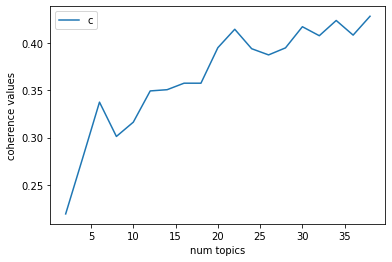

In [20]:
limit=40; start=2; step=2;
model_list, coherence_values = compute_coherence_values(gensim_dict, corpus, tokenize_documents, limit, start, step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('num topics')
plt.ylabel('coherence values')
plt.legend(("coherence_values"), loc="best")
plt.show()